In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.quantum_info import random_statevector
import numpy as np
import scipy
from scipy.optimize import fmin_cobyla
import matplotlib.pyplot as plt

In [2]:
'''
    initial quantum register and quantum circuit for experiment
'''
qr = QuantumRegister(4)
cr = ClassicalRegister(4)

In [3]:
'''
    construct prototype of Even block with rotation Z and control-Z
'''
def Even(params=[0,0,0,0]):
    qc = QuantumCircuit(qr)
    qc.rz(params[0],0)
    qc.rz(params[1],1)
    qc.rz(params[2],2)
    qc.rz(params[3],3)
    qc.cz(0,1)
    qc.cz(0,2)
    qc.cz(0,3)
    qc.cz(1,2)
    qc.cz(1,3)
    qc.cz(2,3)
    return qc

In [4]:
Even().draw()

┌───────┐                  
q0_0: ┤ RZ(0) ├─■──■──■──────────
      ├───────┤ │  │  │          
q0_1: ┤ RZ(0) ├─■──┼──┼──■──■────
      ├───────┤    │  │  │  │    
q0_2: ┤ RZ(0) ├────■──┼──■──┼──■─
      ├───────┤       │     │  │ 
q0_3: ┤ RZ(0) ├───────■─────■──■─
      └───────┘

In [5]:
'''
    construct prototype of Even block with rotation X
'''
def Odd(params=[0,0,0,0]):
    qc = QuantumCircuit(qr)
    qc.rx(params[0],0)
    qc.rx(params[1],1)
    qc.rx(params[2],2)
    qc.rx(params[3],3)
    return qc

In [6]:
Odd().draw()

┌───────┐
q0_0: ┤ RX(0) ├
      ├───────┤
q0_1: ┤ RX(0) ├
      ├───────┤
q0_2: ┤ RX(0) ├
      ├───────┤
q0_3: ┤ RX(0) ├
      └───────┘

In [10]:
'''
    Merge Odd circuit with Even circuit
'''
def LayerBlock(params):
    qc = QuantumCircuit(qr)
    qc+=Odd(params[0:4])
    qc.barrier()
    qc+=Even(params[4:8])
    qc.barrier()
    return qc

In [11]:
LayerBlock([0., 0., 0., 0., 0., 0., 0., 0.]).draw()

┌───────┐ ░ ┌───────┐                   ░ 
q0_0: ┤ RX(0) ├─░─┤ RZ(0) ├─■──■──■───────────░─
      ├───────┤ ░ ├───────┤ │  │  │           ░ 
q0_1: ┤ RX(0) ├─░─┤ RZ(0) ├─■──┼──┼──■──■─────░─
      ├───────┤ ░ ├───────┤    │  │  │  │     ░ 
q0_2: ┤ RX(0) ├─░─┤ RZ(0) ├────■──┼──■──┼──■──░─
      ├───────┤ ░ ├───────┤       │     │  │  ░ 
q0_3: ┤ RX(0) ├─░─┤ RZ(0) ├───────■─────■──■──░─
      └───────┘ ░ └───────┘                   ░

In [12]:
'''
    Construct Task 1 circuit with L parameter
'''
def Task1(L,params):
    qc = QuantumCircuit(qr)
    for i in range(L):
        qc += LayerBlock(params[8*i:8*(i+1)])
    return qc

In [13]:
'''
    Create statevector simulator
'''
simulator = Aer.get_backend('statevector_simulator')

In [14]:
''' 
    initial target state_vector with random_statevector 
'''
random_state_vector = random_statevector(dims=(16,))
random_state_vector = np.array(random_state_vector.data)

In [15]:
random_state_vector

array([ 0.05107696+0.00341823j,  0.02826666+0.17074308j,
       -0.0889887 -0.02024324j,  0.16011937+0.13669637j,
       -0.00338616-0.11225828j,  0.05667918-0.06133786j,
       -0.25822813-0.00259691j,  0.03909941+0.01622338j,
       -0.12662676+0.07059808j,  0.0445706 +0.45438045j,
        0.18013207-0.30342341j,  0.25562404-0.08958301j,
       -0.36392612+0.07302203j, -0.10644832-0.32515043j,
       -0.22362052+0.16522521j,  0.19259454-0.17358092j])

In [72]:
def loss_fn(a,b):
    return np.linalg.norm(a-b)

In [107]:
'''
    construct constraint for optimizer 
'''
Nfeval = 1
L = 5
bounds=[ [0,2*np.pi] for _  in range(L*8)]
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

In [108]:
'''
    define function for our task
'''
history = []
def f(x):
    circ = Task1(L,params=x)
    job = execute(circ, simulator)
    result = job.result()
    state_vector = result.get_statevector(circ)
    loss = loss_fn(state_vector,random_state_vector)
    global Nfeval,history
    history.append(loss)
    print('{0:4d}   {1: 3.6f} '.format(Nfeval, loss))
    Nfeval += 1
    return loss
# def callbackF(x):
#     global Nfeval
#     print('{0:4d}   {1: 3.6f} '.format(Nfeval, f(x)))
#     Nfeval += 1

In [109]:
def constraint_func(x_in):
    constraints_list = []
    constraints_list.append({'type': 'ineq', 'fun': lambda x: np.sum(x)-1})
    constraints_list.append({'type': 'ineq', 'fun': lambda x: -np.sum(x)+1})
    for i in range(len(x_in)):
        constraints_list.append({'type': 'ineq', 'fun': lambda x: x[i]})
    return constraints_list

constraints = constraint_func(bounds)

In [110]:
cons_min=[]
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = lambda x, lb=lower, i=factor: x[i] - lb
    u = lambda x, ub=upper, i=factor: ub - x[i]
    cons_min.append(l)
    cons_min.append(u)

In [111]:
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
rand_params = np.zeros(shape=(L*8,))
res = fmin_cobyla(f,rand_params,cons=cons_min)
# res = scipy.optimize.minimize(f,rand_params,constraints=cons,method='COBYLA',options={'maxiter':200})

Iter   f(X)     
   1    1.377623 
   2    1.440163 
   3    1.375115 
   4    1.388718 
   5    1.371456 
   6    1.371456 
   7    1.451609 
   8    1.371456 
   9    1.448682 
  10    1.443743 
  11    1.410446 
  12    1.264119 
  13    1.266701 
  14    1.264119 
  15    1.366863 
  16    1.342471 
  17    1.380629 
  18    1.299000 
  19    1.254610 
  20    1.383272 
  21    1.297115 
  22    1.254610 
  23    1.386573 
  24    1.313401 
  25    1.397250 
  26    1.366618 
  27    1.253991 
  28    1.149423 
  29    1.153894 
  30    1.149423 
  31    1.304196 
  32    1.283884 
  33    1.293161 
  34    1.160977 
  35    1.162821 
  36    1.306688 
  37    1.144143 
  38    1.144143 
  39    1.323753 
  40    1.216226 
  41    1.288312 
  42    1.123864 
  43    1.149037 
  44    1.112641 
  45    1.045825 
  46    1.077484 
  47    1.047488 
  48    1.051944 
  49    1.045825 
  50    1.086863 
  51    1.059262 
  52    1.118337 
  53    1.012295 
  54    1.055468 
  55    1.0

In [112]:
res

array([-1.62178441e-17,  1.25007423e+00, -1.30713922e-17,  2.44553038e+00,
        2.79617894e-01,  6.86278677e-01,  2.73917850e-01, -3.02189155e-18,
        1.21627520e+00,  1.14467603e-01,  1.90203873e+00,  7.10846372e-01,
        2.26475881e-01,  2.50966900e-01, -6.85907969e-18,  2.97117207e-04,
        9.10694390e-01,  8.35085258e-01,  6.89186133e-01,  6.07498175e-02,
        9.46672150e-17,  5.62570723e-17,  4.78462332e-01, -1.12757026e-17,
        2.46499503e-01,  7.57539109e-02,  3.33913885e+00,  9.73324339e-01,
       -7.75183648e-18,  1.42458243e-17, -1.28710969e-17,  6.97110898e-02,
        7.30179462e-02,  7.13983070e-01,  4.28546337e-18,  1.24355572e+00,
        2.98822471e-01,  6.77516477e-17, -4.44763340e-18,  2.38337382e-01])

In [113]:
circ = Task1(L,params=res)
job = execute(circ, simulator)
result = job.result()
state_vector = result.get_statevector(circ)
print(random_state_vector)
print(state_vector)
print(loss_fn(state_vector,random_state_vector))


[ 0.05107696+0.00341823j  0.02826666+0.17074308j -0.0889887 -0.02024324j
  0.16011937+0.13669637j -0.00338616-0.11225828j  0.05667918-0.06133786j
 -0.25822813-0.00259691j  0.03909941+0.01622338j -0.12662676+0.07059808j
  0.0445706 +0.45438045j  0.18013207-0.30342341j  0.25562404-0.08958301j
 -0.36392612+0.07302203j -0.10644832-0.32515043j -0.22362052+0.16522521j
  0.19259454-0.17358092j]
[ 0.13818939+0.12795644j -0.05109717+0.06175926j  0.00321026+0.01681418j
  0.02564343+0.28674771j -0.05321645-0.08409016j -0.06115687+0.03038113j
 -0.23708989-0.07411516j  0.07378771+0.01659854j -0.01520671+0.08621262j
  0.19413459+0.49663364j  0.10100674-0.28464784j  0.25993531+0.05309249j
 -0.47442726-0.08413845j  0.08401039-0.05476947j -0.20864196+0.13645637j
 -0.01205169-0.18658971j]
0.6142309207998145


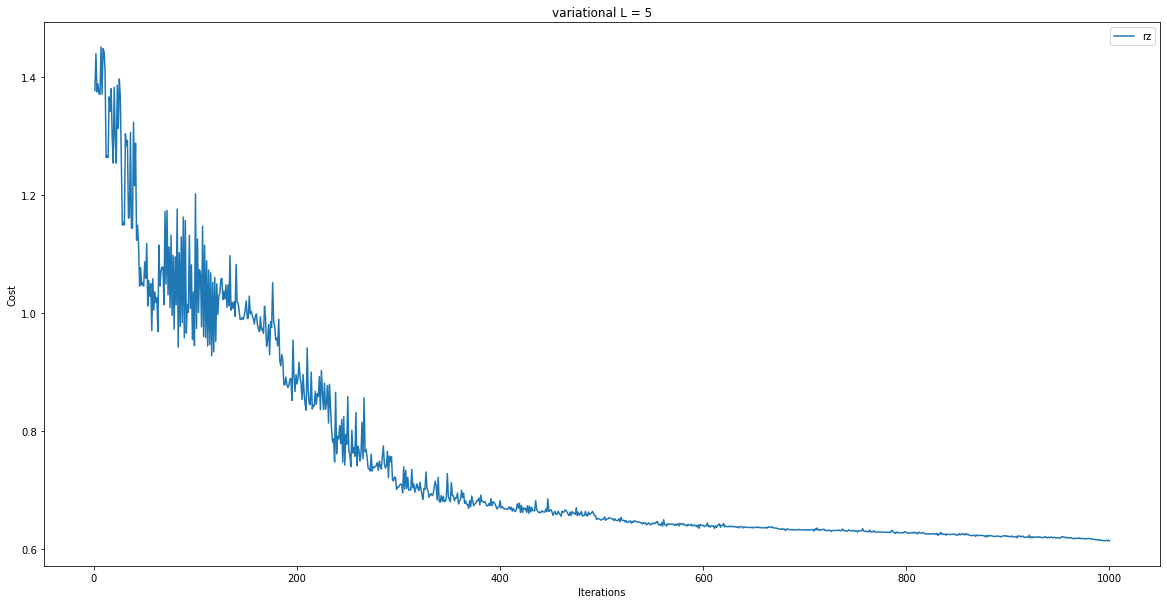

In [114]:
plt.figure(figsize=(20,10))
plt.plot(range(1, len(history) + 1), history)
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('variational L = {}'.format(L))
plt.show()

In [46]:
class variational:
    def __init__(self,L):
        self.QRegister = QuantumRegister(4)
        self.L = L
        self.params = np.zeros(shape=(L*8,))
        self.random_state_vector = np.array(random_statevector(dims=(16,)).data)
        self.simulator = Aer.get_backend('statevector_simulator')
        self.history = []
        bounds = [ [0,2*np.pi] for _ in range(self.L *8)]
        self.cons = []
        self.Nfeval = 1
        for factor in range(len(bounds)):
            lower, upper = bounds[factor]
            l = lambda x, lb=lower, i=factor: x[i] - lb
            u = lambda x, ub=upper, i=factor: ub - x[i]
            self.cons.append(l)
            self.cons.append(u)
    def Even(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.rz(params[0],0)
        qc.rz(params[1],1)
        qc.rz(params[2],2)
        qc.rz(params[3],3)
        qc.cz(0,1)
        qc.cz(0,2)
        qc.cz(0,3)
        qc.cz(1,2)
        qc.cz(1,3)
        qc.cz(2,3)
        return qc
    def Odd(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.rx(params[0],0)
        qc.rx(params[1],1)
        qc.rx(params[2],2)
        qc.rx(params[3],3)
        return qc
    def LayerBlock(self,params):
        qc = QuantumCircuit(self.QRegister)
        qc+=self.Odd(params[0:4])
        qc.barrier()
        qc+=self.Even(params[4:8])
        qc.barrier()
        return qc
    def Task1(self,params):
        qc = QuantumCircuit(self.QRegister)
        for i in range(self.L):
            qc += self.LayerBlock(params[8*i:8*(i+1)])
        return qc
    def loss_fn(self,a,b):
        return np.linalg.norm(a-b)
    def f(self,x):
        circ = self.Task1(params=x)
        job = execute(circ, self.simulator)
        result = job.result()
        state_vector = result.get_statevector(circ)
        circ.draw()
        loss = self.loss_fn(state_vector,self.random_state_vector)
        self.history.append(loss)
        if self.Nfeval % 100 == 0:
            print('{0:4d}   {1: 3.6f} '.format(self.Nfeval, loss))
        self.Nfeval  += 1
        return loss
    def train(self,show=False,maxiter=1000):
        self.Nfeval = 1
        print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
        self.params = np.zeros(shape=(self.L*8,))
        res = fmin_cobyla(self.f,self.params,cons=self.cons,maxfun=maxiter)
        return res,self.history
    def plot(self):
        plt.figure(figsize=(20,10))
        plt.plot(range(1, len(self.history) + 1), self.history, 'b')
        plt.legend(['rz'], loc='upper right')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('variational {}'.format(self.L))
        # plt.show()



In [48]:
experiment = variational(5)
res,history = experiment.train(maxiter=200)

Iter   f(X)     
 100    0.844119 
 200    0.741563 


In [49]:
L_list = [1,3,5,10]
resList = []
historyList = []
for i in L_list:
    experiment = variational(i)
    res,history = experiment.train(maxiter=1000)
    historyList.append(history)

Iter   f(X)     
 100    0.944466 
 200    0.926307 
 300    0.886290 
 400    0.869905 
 500    0.866706 
 600    0.866661 
Iter   f(X)     
 100    0.785030 
 200    0.766344 
 300    0.750476 
 400    0.747038 
 500    0.713917 
 600    0.621452 
 700    0.566134 
 800    0.489062 
 900    0.470331 
1000    0.455680 
Iter   f(X)     
 100    0.814614 
 200    0.857431 
 300    0.681563 
 400    0.645805 
 500    0.617735 
 600    0.595109 
 700    0.570244 
 800    0.542888 
 900    0.517614 
1000    0.497974 
Iter   f(X)     
 100    0.837322 
 200    0.691207 
 300    0.638781 
 400    0.579487 
 500    0.491281 
 600    0.455178 
 700    0.395467 
 800    0.389078 
 900    0.333929 
1000    0.315823 


Text(0.5, 1.0, 'L = 10')

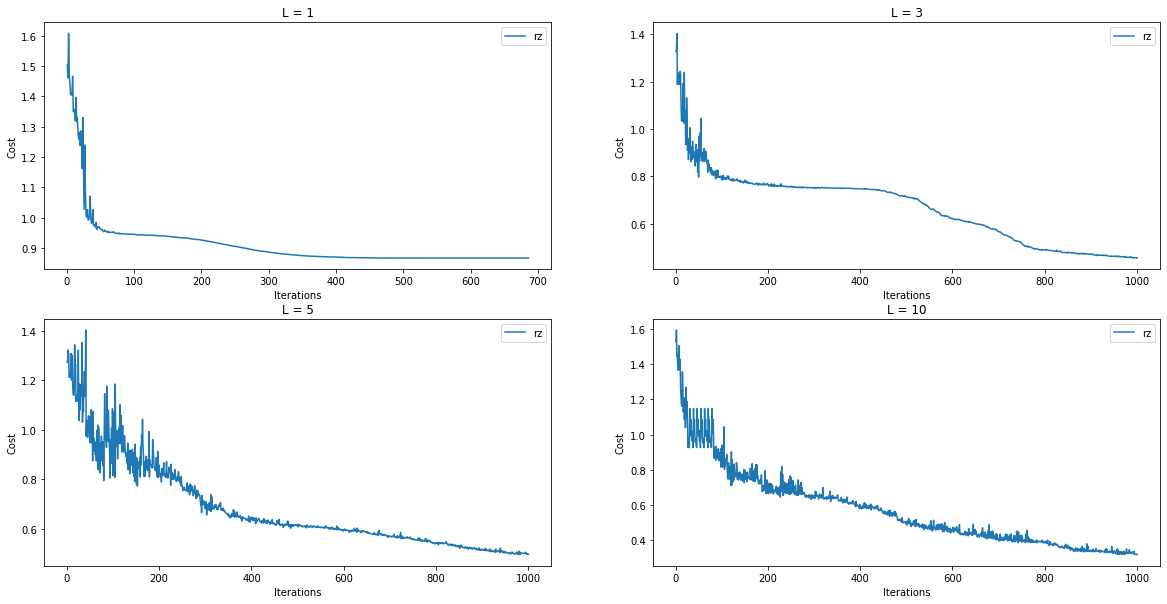

In [51]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(range(1, len(historyList[0]) + 1), historyList[0])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 1')
plt.subplot(222)
plt.plot(range(1, len(historyList[1]) + 1), historyList[1])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 3')
plt.subplot(223)
plt.plot(range(1, len(historyList[2]) + 1), historyList[2])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 5')
plt.subplot(224)
plt.plot(range(1, len(historyList[3]) + 1), historyList[3])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 10')

# Bonus

In [52]:
'''
    Change Rx to Ry gate
'''
class variationalRy:
    def __init__(self,L):
        self.QRegister = QuantumRegister(4)
        self.L = L
        self.params = np.zeros(shape=(L*8,))
        self.random_state_vector = np.array(random_statevector(dims=(16,)).data)
        self.simulator = Aer.get_backend('statevector_simulator')
        self.history = []
        bounds = [ [0,2*np.pi] for _ in range(self.L *8)]
        self.cons = []
        self.Nfeval = 1
        for factor in range(len(bounds)):
            lower, upper = bounds[factor]
            l = lambda x, lb=lower, i=factor: x[i] - lb
            u = lambda x, ub=upper, i=factor: ub - x[i]
            self.cons.append(l)
            self.cons.append(u)
    def Even(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.rz(params[0],0)
        qc.rz(params[1],1)
        qc.rz(params[2],2)
        qc.rz(params[3],3)
        qc.cz(0,1)
        qc.cz(0,2)
        qc.cz(0,3)
        qc.cz(1,2)
        qc.cz(1,3)
        qc.cz(2,3)
        return qc
    def Odd(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.ry(params[0],0)
        qc.ry(params[1],1)
        qc.ry(params[2],2)
        qc.ry(params[3],3)
        return qc
    def LayerBlock(self,params):
        qc = QuantumCircuit(self.QRegister)
        qc+=self.Odd(params[0:4])
        qc.barrier()
        qc+=self.Even(params[4:8])
        qc.barrier()
        return qc
    def Task1(self,params):
        qc = QuantumCircuit(self.QRegister)
        for i in range(self.L):
            qc += self.LayerBlock(params[8*i:8*(i+1)])
        return qc
    def loss_fn(self,a,b):
        return np.linalg.norm(a-b)
    def f(self,x):
        circ = self.Task1(params=x)
        job = execute(circ, self.simulator)
        result = job.result()
        state_vector = result.get_statevector(circ)
        circ.draw()
        loss = self.loss_fn(state_vector,self.random_state_vector)
        self.history.append(loss)
        if self.Nfeval % 100 == 0:
            print('{0:4d}   {1: 3.6f} '.format(self.Nfeval, loss))
        self.Nfeval  += 1
        return loss
    def train(self,show=False,maxiter=1000):
        self.Nfeval = 1
        print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
        self.params = np.zeros(shape=(self.L*8,))
        res = fmin_cobyla(self.f,self.params,cons=self.cons,maxfun=maxiter)
        return res,self.history
    def plot(self):
        plt.figure(figsize=(20,10))
        plt.plot(range(1, len(self.history) + 1), self.history, 'b')
        plt.legend(['rz'], loc='upper right')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('variational {}'.format(self.L))
        # plt.show()



In [54]:
experiment = variationalRy(5)
res,history = experiment.train(maxiter=3000)

Iter   f(X)     
 100    0.890834 
 200    0.705565 
 300    0.647718 
 400    0.621371 
 500    0.605044 
 600    0.583464 
 700    0.569519 
 800    0.565912 
 900    0.546128 
1000    0.537269 
1100    0.528814 
1200    0.520695 
1300    0.515281 
1400    0.507205 
1500    0.504534 
1600    0.500111 
1700    0.496028 
1800    0.493328 
1900    0.489634 
2000    0.486864 
2100    0.484863 
2200    0.481359 
2300    0.478656 
2400    0.473333 
2500    0.471242 
2600    0.466922 
2700    0.462337 
2800    0.458434 
2900    0.451888 
3000    0.445292 


In [60]:
experiment.random_state_vector.reshape(2,8)

array([[-0.00455766+0.2530012j , -0.26267677-0.12333621j,
         0.22751903+0.15893096j,  0.01597803+0.07543964j,
        -0.08717238+0.16240691j, -0.26604115-0.07004813j,
        -0.22892531+0.3892924j , -0.35665212-0.04034556j],
       [ 0.16950598+0.09652346j, -0.17193544+0.02036057j,
         0.24798012+0.06692649j,  0.09785499+0.06979891j,
         0.00836902-0.04496362j, -0.04450669-0.26246698j,
        -0.19441792-0.19294579j,  0.12458183-0.11995849j]])

In [63]:
experiment.Task1(res).draw()

┌─────────────┐ ░   ┌────────────┐                     ░  ┌────────────┐»
q29_0: ┤ RY(0.31612) ├─░───┤ RZ(2.1476) ├───■──■──■───────────░──┤ RY(1.3775) ├»
       ├─────────────┤ ░  ┌┴────────────┤   │  │  │           ░  ├────────────┤»
q29_1: ┤ RY(0.95784) ├─░──┤ RZ(0.36422) ├───■──┼──┼──■──■─────░──┤ RY(1.5606) ├»
       ├─────────────┤ ░  └──┬───────┬──┘      │  │  │  │     ░  ├────────────┤»
q29_2: ┤ RY(0.98092) ├─░─────┤ RZ(0) ├─────────■──┼──■──┼──■──░──┤ RY(1.7674) ├»
       └┬────────────┤ ░ ┌───┴───────┴────┐       │     │  │  ░ ┌┴────────────┤»
q29_3: ─┤ RY(0.7903) ├─░─┤ RZ(0.00077782) ├───────■─────■──■──░─┤ RY(0.73851) ├»
        └────────────┘ ░ └────────────────┘                   ░ └─────────────┘»
«        ░ ┌─────────────┐                    ░    ┌───────┐    ░ »
«q29_0: ─░─┤ RZ(0.99469) ├──■──■──■───────────░────┤ RY(0) ├────░─»
«        ░ ├─────────────┴┐ │  │  │           ░    ├───────┤    ░ »
«q29_1: ─░─┤ RZ(0.020059) ├─■──┼──┼──■──■─────░────┤ RY(0) ├────░─»
«        ░ └┬────────────┬┘    │  │  │  │     ░ ┌──┴───────┴──┐ ░ »
«q29_2: ─░──┤ RZ(1.3062) ├─────■──┼──■──┼──■──░─┤ RY(0.24521) ├─░─»
«        ░ ┌┴────────────┤        │     │  │  ░ ├─────────────┤ ░ »
«q29_3: ─░─┤ RZ(0.75222) ├────────■─────■──■──░─┤ RY(0.28054) ├─░─»
«        ░ └─────────────┘                    ░ └─────────────┘ ░ »
«       ┌─────────────┐                    ░  ┌────────────┐  ░ »
«q29_0: ┤ RZ(0.91968) ├──■──■──■───────────░──┤ RY(2.0043) ├──░─»
«       ├─────────────┴┐ │  │  │           ░ ┌┴────────────┤  ░ »
«q29_1: ┤ RZ(0.059307) ├─■──┼──┼──■──■─────░─┤ RY(0.31929) ├──░─»
«       ├─────────────┬┘    │  │  │  │     ░ └──┬───────┬──┘  ░ »
«q29_2: ┤ RZ(0.46081) ├─────■──┼──■──┼──■──░────┤ RY(0) ├─────░─»
«       ├─────────────┤        │     │  │  ░ ┌──┴───────┴───┐ ░ »
«q29_3: ┤ RZ(0.36463) ├────────■─────■──■──░─┤ RY(0.035328) ├─░─»
«       └─────────────┘                    ░ └──────────────┘ ░ »
«       ┌──────────────┐                   ░   ┌────────────┐  ░ »
«q29_0: ┤ RZ(0.047648) ├─■──■──■───────────░───┤ RY(1.0314) ├──░─»
«       ├──────────────┤ │  │  │           ░   └─┬───────┬──┘  ░ »
«q29_1: ┤ RZ(0.060775) ├─■──┼──┼──■──■─────░─────┤ RY(0) ├─────░─»
«       ├─────────────┬┘    │  │  │  │     ░     ├───────┤     ░ »
«q29_2: ┤ RZ(0.95662) ├─────■──┼──■──┼──■──░─────┤ RY(0) ├─────░─»
«       ├─────────────┴┐       │     │  │  ░ ┌───┴───────┴───┐ ░ »
«q29_3: ┤ RZ(0.026621) ├───────■─────■──■──░─┤ RY(0.0070946) ├─░─»
«       └──────────────┘                   ░ └───────────────┘ ░ »
«       ┌────────────────┐                   ░ 
«q29_0: ┤ RZ(6.5617e-05) ├─■──■──■───────────░─
«       └┬─────────────┬─┘ │  │  │           ░ 
«q29_1: ─┤ RZ(0.11617) ├───■──┼──┼──■──■─────░─
«        └┬────────────┤      │  │  │  │     ░ 
«q29_2: ──┤ RZ(0.1769) ├──────■──┼──■──┼──■──░─
«        ┌┴────────────┴┐        │     │  │  ░ 
«q29_3: ─┤ RZ(0.049232) ├────────■─────■──■──░─
«        └──────────────┘                    ░

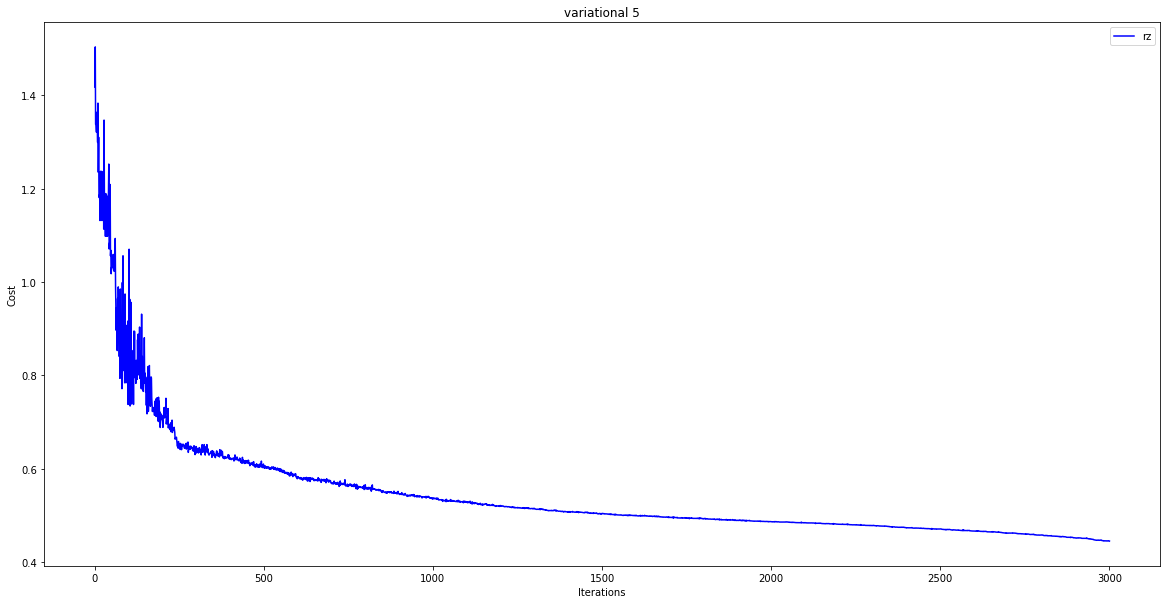

In [55]:
experiment.plot()